In [ ]:
import torch
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]
        return image, label

In [ ]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Define the neural network model
class ShallowFCNN(nn.Module):
    def __init__(self, k, p):
        super(ShallowFCNN, self).__init__()
        self.fc1 = nn.Linear(784, k)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)
        self.fc2 = nn.Linear(k, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Hyperparameters
k_values = [1, 5, 10, 20, 40] #width grid
p_values = [0.1, 0.5, 1.0]  #dropout grid
num_epochs = 80
batch_size = 64
learning_rate = 0.001

In [ ]:
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

# Split the dataset into training and test datasets
train_data, train_labels = train_dataset.data, train_dataset.targets
test_data, test_labels = test_dataset.data, test_dataset.targets

# Normalize the data (zero mean and unit variance)
train_data = (train_data.float() - train_data.float().mean()) / train_data.float().std()
test_data = (test_data.float() - test_data.float().mean()) / test_data.float().std()

# Reduce the size of the training data by randomly selecting 1000 samples of each class
classes = torch.unique(train_labels)
reduced_train_data = []
reduced_train_labels = []
num_samples_per_class = 1000

for class_label in classes:
    class_indices = torch.where(train_labels == class_label)[0]
    selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class]
    reduced_train_data.append(train_data[class_indices[selected_indices]])
    reduced_train_labels.append(train_labels[class_indices[selected_indices]])

# Concatenate the reduced training data and labels
reduced_train_data = torch.cat(reduced_train_data, dim=0)
reduced_train_labels = torch.cat(reduced_train_labels, dim=0)

new_train_dataset = CustomDataset(reduced_train_data,reduced_train_labels)
new_test_dataset = CustomDataset(test_data,test_labels)

# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=new_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=new_test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 138833290.18it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 87715926.01it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39376050.59it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15941865.08it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def trainAndTest(k, p):

    print(f'Function call for k = : {k}')
    print(f'And p = : {1-p:.2f}')

    # Initialize the model
    model = ShallowFCNN(k, p)

    # Initialize the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    training_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            # Flatten the input images from shape (batch_size, 1, 28, 28) to (batch_size, 784)
            images = images.view(-1, 28*28)

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Print the loss after every epoch
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
        
        # Calculate Training accuracy
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in train_loader:
                images = images.view(-1, 28*28)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        training_accuracies.append(accuracy)
        
    best_train_acc = max(training_accuracies)
    print(f'Train Accuracy: {best_train_acc}%')

    # Evaluation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.view(-1, 28*28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        print(f'Test Accuracy: {test_accuracy}%')

    return best_train_acc, test_accuracy

In [ ]:
mainListForTrain = []
mainListForTest = []

for k in k_values:
  trainAccuracies = []
  testAccuracies = []
  for p in p_values:
    trAcc, teAcc = trainAndTest(k, 1 - p)
    # print(f'Train Accuracy: {trAcc}%')
    # print(f'Test Accuracy: {teAcc}%')
    trainAccuracies.append(trAcc)
    testAccuracies.append(teAcc)
    print(trainAccuracies)
    print(testAccuracies)
  mainListForTrain.append(trainAccuracies)
  mainListForTest.append(testAccuracies)

Function call for k = : 1
And p = : 0.10
Train Accuracy: 10.0%
Test Accuracy: 9.8%
[10.0]
[9.8]
Function call for k = : 1
And p = : 0.50
Train Accuracy: 10.0%
Test Accuracy: 9.58%
[10.0, 10.0]
[9.8, 9.58]
Function call for k = : 1
And p = : 1.00
Train Accuracy: 10.0%
Test Accuracy: 9.58%
[10.0, 10.0, 10.0]
[9.8, 9.58, 9.58]
Function call for k = : 5
And p = : 0.10
Train Accuracy: 13.4%
Test Accuracy: 55.0%
[13.4]
[55.0]
Function call for k = : 5
And p = : 0.50
Train Accuracy: 43.94%
Test Accuracy: 73.04%
[13.4, 43.94]
[55.0, 73.04]
Function call for k = : 5
And p = : 1.00
Train Accuracy: 92.83%
Test Accuracy: 87.66%
[13.4, 43.94, 92.83]
[55.0, 73.04, 87.66]
Function call for k = : 10
And p = : 0.10
Train Accuracy: 17.67%
Test Accuracy: 64.88%
[17.67]
[64.88]
Function call for k = : 10
And p = : 0.50
Train Accuracy: 62.74%
Test Accuracy: 86.47%
[17.67, 62.74]
[64.88, 86.47]
Function call for k = : 10
And p = : 1.00
Train Accuracy: 97.8%
Test Accuracy: 89.67%
[17.67, 62.74, 97.8]
[64.88,

Code to plot graphs

[[10.0, 10.0, 10.0], [13.4, 43.94, 92.83], [17.67, 62.74, 97.8], [24.04, 81.32, 100.0], [38.9, 93.17, 100.0]]
[[9.8, 9.58, 9.58], [55.0, 73.04, 87.66], [64.88, 86.47, 89.67], [85.08, 91.16, 92.79], [88.81, 93.93, 94.97]]


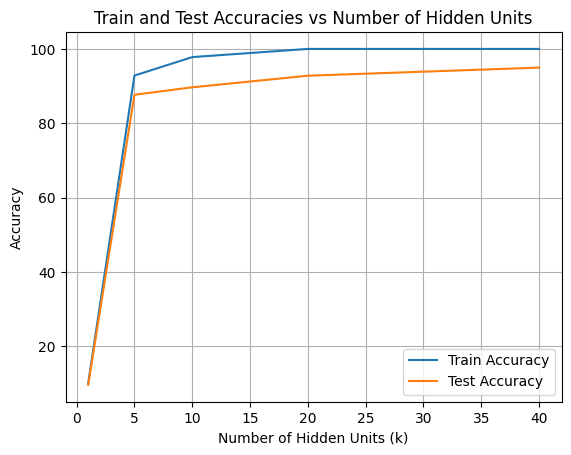

In [ ]:
import matplotlib.pyplot as plt

#2.1 p = 1 No dropout regularization. Training and testing accuracies vs k.

print(mainListForTrain)
print(mainListForTest)

train_accuracies = []
test_accuracies = []

# Train accuracies and test accuracies lists
for i, j in zip(mainListForTrain, mainListForTest):
  train_accuracies.append(i[2])
  test_accuracies.append(j[2])

# Plotting the accuracies vs k
plt.plot(k_values, train_accuracies, label='Train Accuracy')
plt.plot(k_values, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Hidden Units (k)')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracies vs Number of Hidden Units')
plt.legend()
plt.grid(True)
plt.show()


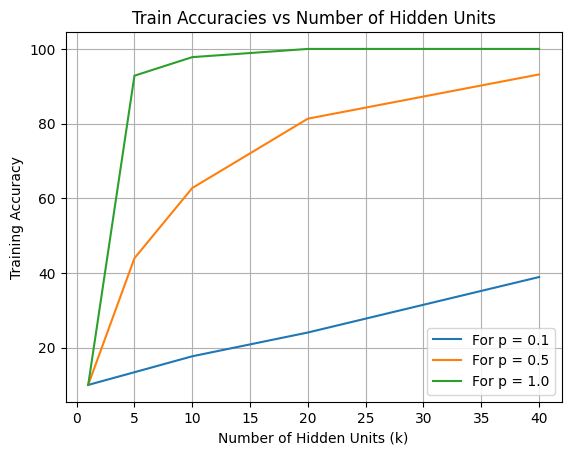

In [ ]:
#2.2 Training accuracies vs k for all p values.
train_accuracies1 = []
test_accuracies1 = []

train_accuracies2 = []
test_accuracies2 = []

train_accuracies3 = []
test_accuracies3 = []

# Train accuracies and test accuracies lists
for i, j in zip(mainListForTrain, mainListForTest):
  train_accuracies1.append(i[0])
  test_accuracies1.append(j[0])
  train_accuracies2.append(i[1])
  test_accuracies2.append(j[1])
  train_accuracies3.append(i[2])
  test_accuracies3.append(j[2])

# Plotting the accuracies vs k
plt.plot(k_values, train_accuracies1, label='For p = 0.1')
plt.plot(k_values, train_accuracies2, label='For p = 0.5')
plt.plot(k_values, train_accuracies3, label='For p = 1.0')
plt.xlabel('Number of Hidden Units (k)')
plt.ylabel('Training Accuracy')
plt.title('Train Accuracies vs Number of Hidden Units')
plt.legend()
plt.grid(True)
plt.show()


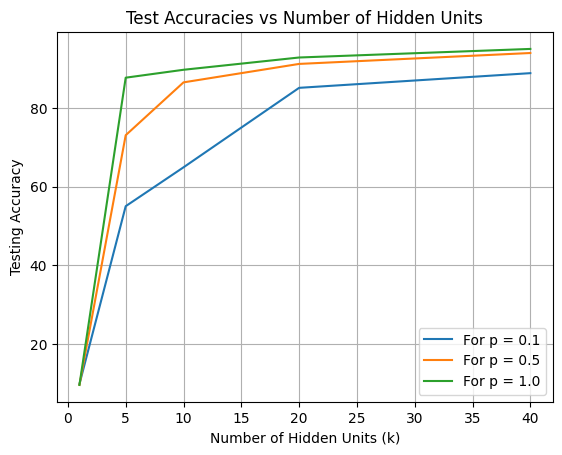

In [ ]:
#2.3 Testing accuracies vs k for all p values.

# Plotting the accuracies vs k
plt.plot(k_values, test_accuracies1, label='For p = 0.1')
plt.plot(k_values, test_accuracies2, label='For p = 0.5')
plt.plot(k_values, test_accuracies3, label='For p = 1.0')
plt.xlabel('Number of Hidden Units (k)')
plt.ylabel('Testing Accuracy')
plt.title('Test Accuracies vs Number of Hidden Units')
plt.legend()
plt.grid(True)
plt.show()

Adding Noise

In [ ]:
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

# Split the dataset into training and test datasets
train_data, train_labels = train_dataset.data, train_dataset.targets
test_data, test_labels = test_dataset.data, test_dataset.targets

# Normalize the data (zero mean and unit variance)
train_data = (train_data.float() - train_data.float().mean()) / train_data.float().std()
test_data = (test_data.float() - test_data.float().mean()) / test_data.float().std()

# Reduce the size of the training data by randomly selecting 1000 samples of each class
classes = torch.unique(train_labels)
reduced_train_data = []
reduced_train_labels = []
num_samples_per_class = 1000

for class_label in classes:
    class_indices = torch.where(train_labels == class_label)[0]
    selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class]
    reduced_train_data.append(train_data[class_indices[selected_indices]])
    reduced_train_labels.append(train_labels[class_indices[selected_indices]])

# Concatenate the reduced training data and labels
reduced_train_data = torch.cat(reduced_train_data, dim=0)
reduced_train_labels = torch.cat(reduced_train_labels, dim=0)

In [ ]:
# Hyperparameters
k_values = [1, 5, 10, 20, 40] #width grid
p_values = [0.1, 0.5, 1.0]  #dropout grid
num_epochs = 80
batch_size = 64
learning_rate = 0.0001

In [ ]:
import numpy as np

# Number of samples to randomly assign incorrect labels
num_samples = int(0.4 * len(reduced_train_labels))
copy_of_org = reduced_train_labels.clone()

# Randomly select indices of samples to assign incorrect labels
indices = np.random.choice(len(reduced_train_labels), num_samples, replace=False)

# Assign incorrect labels to the selected samples
for index in indices:
    original_label = reduced_train_labels[index]
    incorrect_label = np.random.choice([i for i in range(10) if i != original_label])
    reduced_train_labels[index] = incorrect_label
  
print((copy_of_org == reduced_train_labels).sum())

tensor(6000)


In [ ]:
new_train_dataset = CustomDataset(reduced_train_data,reduced_train_labels)
new_test_dataset = CustomDataset(test_data,test_labels)

# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=new_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=new_test_dataset, batch_size=batch_size, shuffle=False)

Train and Test for all values of k and p

In [ ]:
mainListForTrain = []
mainListForTest = []

for k in k_values:
  trainAccuracies = []
  testAccuracies = []
  for p in p_values:
    trAcc, teAcc = trainAndTest(k, 1 - p)
    trainAccuracies.append(trAcc)
    testAccuracies.append(teAcc)
    print(trainAccuracies)
    print(testAccuracies)
  mainListForTrain.append(trainAccuracies)
  mainListForTest.append(testAccuracies)

Function call for k = : 1
And p = : 0.10
Train Accuracy: 10.76%
Test Accuracy: 12.59%
[10.76]
[12.59]
Function call for k = : 1
And p = : 0.50
Train Accuracy: 14.01%
Test Accuracy: 21.3%
[10.76, 14.01]
[12.59, 21.3]
Function call for k = : 1
And p = : 1.00
Train Accuracy: 16.34%
Test Accuracy: 20.09%
[10.76, 14.01, 16.34]
[12.59, 21.3, 20.09]
Function call for k = : 5
And p = : 0.10
Train Accuracy: 12.08%
Test Accuracy: 34.24%
[12.08]
[34.24]
Function call for k = : 5
And p = : 0.50
Train Accuracy: 26.82%
Test Accuracy: 76.62%
[12.08, 26.82]
[34.24, 76.62]
Function call for k = : 5
And p = : 1.00
Train Accuracy: 46.98%
Test Accuracy: 73.22%
[12.08, 26.82, 46.98]
[34.24, 76.62, 73.22]
Function call for k = : 10
And p = : 0.10
Train Accuracy: 15.03%
Test Accuracy: 68.73%
[15.03]
[68.73]
Function call for k = : 10
And p = : 0.50
Train Accuracy: 37.97%
Test Accuracy: 86.76%
[15.03, 37.97]
[68.73, 86.76]
Function call for k = : 10
And p = : 1.00
Train Accuracy: 55.61%
Test Accuracy: 87.46%


Plots

[[10.76, 14.01, 16.34], [12.08, 26.82, 46.98], [15.03, 37.97, 55.61], [18.78, 47.02, 56.93], [26.33, 53.19, 58.63]]
[[12.59, 21.3, 20.09], [34.24, 76.62, 73.22], [68.73, 86.76, 87.46], [83.97, 89.21, 88.2], [89.5, 90.42, 88.81]]


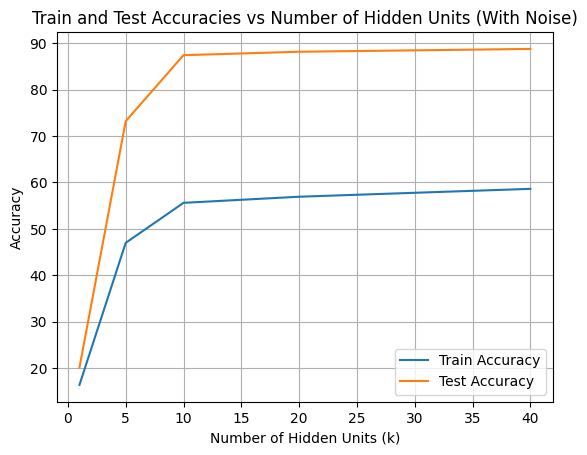

In [ ]:
#3.1 p = 1 No dropout regularization. Training and testing accuracies vs k.

import matplotlib.pyplot as plt


print(mainListForTrain)
print(mainListForTest)

train_accuracies = []
test_accuracies = []

# Train accuracies and test accuracies lists
for i, j in zip(mainListForTrain, mainListForTest):
  train_accuracies.append(i[2])
  test_accuracies.append(j[2])

# Plotting the accuracies vs k
plt.plot(k_values, train_accuracies, label='Train Accuracy')
plt.plot(k_values, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Hidden Units (k)')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracies vs Number of Hidden Units (With Noise)')
plt.legend()
plt.grid(True)
plt.show()


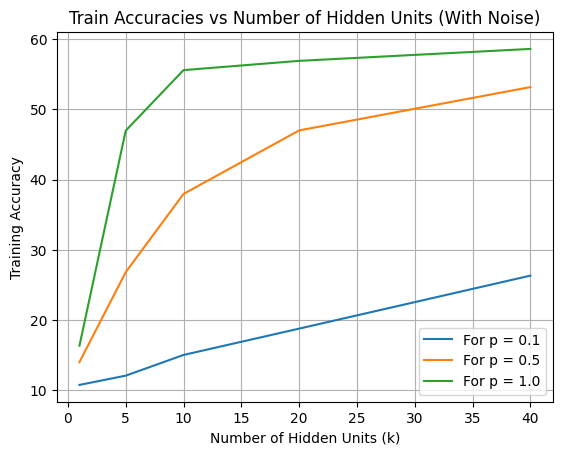

In [ ]:
#3.2 Training accuracies vs k for all p values.
train_accuracies1 = []
test_accuracies1 = []

train_accuracies2 = []
test_accuracies2 = []

train_accuracies3 = []
test_accuracies3 = []

# Train accuracies and test accuracies lists
for i, j in zip(mainListForTrain, mainListForTest):
  train_accuracies1.append(i[0])
  test_accuracies1.append(j[0])
  train_accuracies2.append(i[1])
  test_accuracies2.append(j[1])
  train_accuracies3.append(i[2])
  test_accuracies3.append(j[2])

# Plotting the accuracies vs k
plt.plot(k_values, train_accuracies1, label='For p = 0.1')
plt.plot(k_values, train_accuracies2, label='For p = 0.5')
plt.plot(k_values, train_accuracies3, label='For p = 1.0')
plt.xlabel('Number of Hidden Units (k)')
plt.ylabel('Training Accuracy')
plt.title('Train Accuracies vs Number of Hidden Units (With Noise)')
plt.legend()
plt.grid(True)
plt.show()

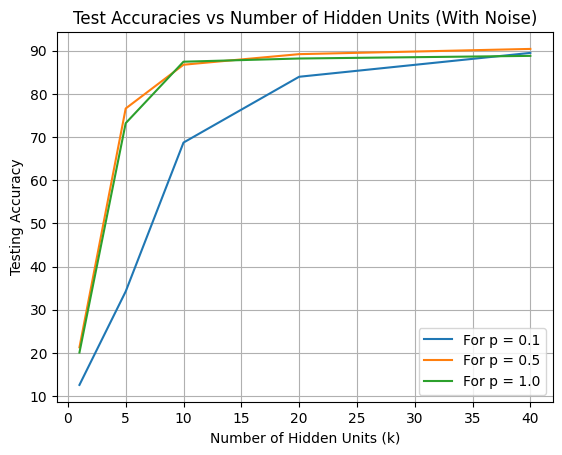

In [ ]:
#3.3 Testing accuracies vs k for all p values.

# Plotting the accuracies vs k
plt.plot(k_values, test_accuracies1, label='For p = 0.1')
plt.plot(k_values, test_accuracies2, label='For p = 0.5')
plt.plot(k_values, test_accuracies3, label='For p = 1.0')
plt.xlabel('Number of Hidden Units (k)')
plt.ylabel('Testing Accuracy')
plt.title('Test Accuracies vs Number of Hidden Units (With Noise)')
plt.legend()
plt.grid(True)
plt.show()